# MedNIST using MONAI

I attempted to use MONAI 0.2.0rc2 on 7/2/2020, but it seems like there are some bugs, so I went with the most stable version prior to that, which was 0.1.0, which can be installed using `pip install monai==0.1.0`.

As shown in the MONAI MedNIST Tutorial, the data can be downloaded using `!wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz`. If you wish to untar this file, you can use the following code:

```python
# unzip the '.tar.gz' file to the current directory
import tarfile
datafile = tarfile.open("MedNIST.tar.gz")
datafile.extractall()
datafile.close()
```

In [1]:
# To handle the files
import os
from pathlib import Path


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from argparse import Namespace
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

import monai
from monai.config import print_config
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.networks.nets import densenet121
#from monai.metrics import compute_roc_auc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

np.random.seed(0)
print_config()

MONAI version: 0.1.0
Python version: 3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00)  [GCC 7.5.0]
Numpy version: 1.18.5
Pytorch version: 1.5.1
Ignite version: 0.3.0


I do not ~~normally~~ use Ignite, but I believe MONAI includes it as a requirement (although I could be wrong about that).

# Getting the image files in order

The MONAI tutorial uses `os` rather than `pathlib.Path`, which is what I prefer. I ended up tweaking the code to play nicely with `pathlib.Path`. It was only later that I saw that `rising` in their tutorial had also made the swap. Unsurprisingly, our code ends up looking almost the same. I was curious to see which of the two - `os` versus `pathlib.Path` - was faster because (at least subjectively) `os` seemed snappier.

In [2]:
%%timeit

# `os` version
data_dir = str(Path.cwd().parent / 'data' / 'MedNIST')
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

205 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%%timeit

# my `pathlib` version
data_dir = Path.cwd().parent / 'data' / 'MedNIST'
class_names = sorted( [x.stem for x in data_dir.iterdir() if x.is_dir()] )
num_class = len(class_names)
image_files = [list( (data_dir / c).glob("*.jpeg") ) for c in class_names]  # I went with `glob`

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

292 ms ± 651 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%%timeit

# rising's `pathlib` version (non-glob)
data_dir = Path.cwd().parent / 'data' / 'MedNIST'
class_names = sorted([p.stem for p in data_dir.iterdir() if p.is_dir()])
num_class = len(class_names)

image_files = [[x for x in (data_dir / class_name).iterdir()] for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))

num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

170 ms ± 594 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It seems as though `pathlib.Path` can be faster, but that using the "non-glob" version of the code will get you there.

In [5]:
data_dir = Path.cwd().parent / 'data' / 'MedNIST'
class_names = sorted([p.stem for p in data_dir.iterdir() if p.is_dir()])
num_class = len(class_names)

image_files = [[x for x in (data_dir / class_name).iterdir()] for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))

num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


# Visualize a random subset of the image files with the associated label

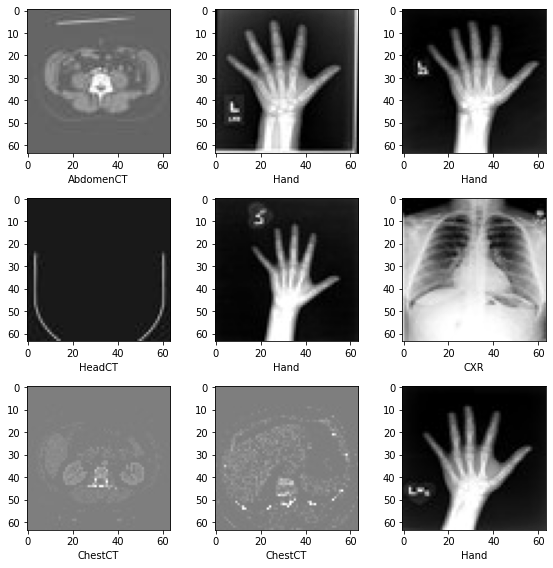

In [6]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Create training, validation and test sets

Options include: 

- Using scikit-learn's `train_test_split`
- Using PyTorch's `random_split` (not shown)
- A good ol' for loop

## For loop approach:

```python
#from MONAI tutorial
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))
```

## Scikit-learn approach

I favor this approach because it allows me to easily stratify the label classes across the training, validation and test sets.

```python
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))
```

# Create `Dataset`

I used the classic `torch.utils.data.Dataset`, i.e. the PyTorch's native `Dataset` class, but others could have also been used. They are all just building off of this one anyway.

In [7]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        """
        Args:
          image_files: paths to the image files
          labels: label for each file
          transforms: the MONAI transforms you want to use
        """
        assert len(image_files) == len(labels), "Every file needs a label"
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self) -> int:
        """
        Number of samples inside the dataset

        Returns:
          int: length
        """
        return len(self.image_files)

    def __getitem__(self, index):
        """
        Select an individual sample from the dataset
        
        Args:
          index: index of sample to draw
          
        Return:
          A tuple containing a single sample of image data and its label
        """
        return self.transforms(self.image_files[index]), self.labels[index]

# PyTorch Lightning

In [8]:
#Hyperparameters
# bs = 300
# num_workers = 10
# #lr = 1e-3

hparams = Namespace(
    batch_size = 300,
    num_workers = 10,
    learning_rate=0.001,
)


class Net(pl.LightningModule):
    def __init__(self, hparams=hparams, *args, **kwargs):
        super(Net, self).__init__()
        self.model = monai.networks.nets.densenet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.hparams = hparams
        self.learning_rate = hparams.learning_rate
        self.batch_size = hparams.batch_size
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        #x, y = batch['image'], batch['label']
        x, y = batch
        y_hat = self.forward(x)
        
        loss = self.loss_function(y_hat, y)
        tensorboard_logs = {'train_loss': loss.item()}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        #x, y = batch['image'], batch['label']
        x, y = batch
        y_hat = self.forward(x)
        return {'val_loss': self.loss_function(y_hat, y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        print(f'Average validation loss for Epoch {trainer.current_epoch + 1}: {avg_loss}')
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    #TEST LOOP
    def test_step(self, batch, batch_idx):
        #x, y = batch['image'], batch['label']
        x, y = batch
        y_hat = self.forward(x)
        return {'test_loss': self.loss_function(y_hat, y)}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}

    # OPTIMIZER
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    #DATASET + TRANSFORMS
    def prepare_data(self):
        train_transforms = Compose([LoadPNG(), AddChannel(), ScaleIntensity(), RandRotate(degrees=15, prob=0.5, reshape=False), RandFlip(spatial_axis=0, prob=0.5),
                                    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True), ToTensor()])
        val_transforms = Compose([LoadPNG(), AddChannel(), ScaleIntensity(), ToTensor()])
        
        data_dir = str(Path.cwd().parent / 'data' / 'MedNIST')
        class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
        num_class = len(class_names)
        image_files = [[os.path.join(data_dir, class_name, x)
                        for x in os.listdir(os.path.join(data_dir, class_name))] 
                       for class_name in class_names]
        image_file_list = []
        image_label_list = []
        for i, class_name in enumerate(class_names):
            image_file_list.extend(image_files[i])
            image_label_list.extend([i] * len(image_files[i]))
        
        X_trainval, X_test, y_trainval, y_test = train_test_split(image_file_list, image_label_list, test_size=0.1, stratify=image_label_list)
        X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval)
        
        #train_dict = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(X_train, y_train)]
        #val_dict = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(X_val, y_val)]
        #test_dict = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(X_test, y_test)]
        
        # Create datasets
        #self.train_dataset = monai.data.Dataset(train_dict, transform=train_transforms)
        #self.val_dataset = monai.data.Dataset(val_dict, transform=val_transforms)
        #self.test_dataset = monai.data.Dataset(test_dict, transform=val_transforms)
        self.train_dataset = MedNISTDataset(X_train, y_train, train_transforms)
        self.val_dataset = MedNISTDataset(X_val, y_val, val_transforms)
        self.test_dataset = MedNISTDataset(X_test, y_test, val_transforms)
        
    # DATALOADERS
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.hparams.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.hparams.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.hparams.num_workers, shuffle=False)

Normally when I'm testing out code, I like to examine the learning rate finder plot. Under these circumstances, I run roughly the following code:

```python
model = Net()

# Learning rate finder
trainer = Trainer(gpus=1)
lr_finder = trainer.lr_find(model)
#Results
#lr_finder.results
#Plot results
fig = lr_finder.plot(suggest=True)
fig.show()
#get suggestion
new_lr = lr_finder.suggestion()

model.hparams.learning_rate = new_lr
```

This will print out a pretty plot with the suggested learning rate highlighted. PyTorch Lighting includes the `auto_lr_find` argument, which I'd like to try out here. I haven't previously used the `auto_scale_batch_size` option, so I'll give it a shot here as well. Seems like a brute force approach to figure out the optimal batch size before running into the OOM error problem (inspired by 'Torch Memory-adaptive Algorithms' (TOMA): [GitHub](https://github.com/BlackHC/toma)).

The default method begins with a much lower batch size than I would prefer for this particular dataset, so I wonder if the preferred approach would be to determine the maximum tolerable batch size using the following:

```python
model = Net()

trainer = Trainer(gpus=1)

new_batch_size = trainer.scale_batch_size(model, mode='binsearch', steps_per_trial=3, init_val=256, max_trials=10, batch_arg_name='batch_size')
model.hparams.batch_size = new_batch_size
```

> Using 'power' the `batch_size` is set to 512, whereas using 'binsearch' it is 816. Using the above code, we find the max tolerable batch size on my GPU is 952.

In [11]:
model = Net()

trainer = Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [12]:
new_batch_size = trainer.scale_batch_size(model, mode='binsearch', steps_per_trial=3, init_val=512, max_trials=10, batch_arg_name='batch_size')

Average validation loss for Epoch 1: 1.7977173328399658


Batch size 512 succeeded, trying batch size 1024


Average validation loss for Epoch 1: 1.564561128616333


Batch size 1024 failed, trying batch size 768


Average validation loss for Epoch 1: 1.5562856197357178


Batch size 768 succeeded, trying batch size 896


Average validation loss for Epoch 1: 1.5530883073806763


Batch size 896 succeeded, trying batch size 960


Average validation loss for Epoch 1: 1.4316909313201904


Batch size 960 failed, trying batch size 928


Average validation loss for Epoch 1: 1.4176322221755981


Batch size 928 succeeded, trying batch size 944


Average validation loss for Epoch 1: 2.1878929138183594


Batch size 944 succeeded, trying batch size 952


Average validation loss for Epoch 1: 1.254901647567749


Batch size 952 succeeded, trying batch size 956


Average validation loss for Epoch 1: 1.1281368732452393


Batch size 956 failed, trying batch size 954


Average validation loss for Epoch 1: 1.0074009895324707


Batch size 954 failed, trying batch size 953


Average validation loss for Epoch 1: 0.7848701477050781


Batch size 953 failed, trying batch size 952
Finished batch size finder, will continue with full run using batch size 952


In [13]:
model.hparams.batch_size = new_batch_size

In [14]:
model.hparams

"batch_size":    952
"learning_rate": 0.001
"num_workers":   10

In [15]:
model = Net()

#Early Stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=False,
    mode='min'
)

#Save model with the whenever 'val_loss' has a new 'min'
checkpoint_callback = ModelCheckpoint(filepath= Path.cwd() /'mednist_{epoch}-{val_loss:.3f}',
                                      monitor='val_loss', mode='min', save_top_k=2)

#trainer = Trainer(fast_dev_run=True, gpus=1)                   # Unit Testing
#trainer = Trainer(overfit_pct=0.01, gpus=1, max_epochs=5)      # Overfit test
trainer = Trainer(max_epochs=15, gpus=1, 
                  auto_lr_find=True, #auto_scale_batch_size='power',
                  early_stop_callback=early_stop_callback, checkpoint_callback=checkpoint_callback)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | DenseNet         | 6 M   
1 | loss_function | CrossEntropyLoss | 0     


Average validation loss for Epoch 1: 1.808056116104126


Learning rate set to 0.0004365158322401656

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | DenseNet         | 6 M   
1 | loss_function | CrossEntropyLoss | 0     


Average validation loss for Epoch 2: 1.808056116104126


Average validation loss for Epoch 2: 0.0126252556219697


Average validation loss for Epoch 3: 0.004475963301956654


Average validation loss for Epoch 4: 0.006038493476808071


Average validation loss for Epoch 5: 0.009723618626594543


Average validation loss for Epoch 6: 0.0035529318265616894


Average validation loss for Epoch 7: 0.00670781172811985


Average validation loss for Epoch 8: 0.002551330951973796


Average validation loss for Epoch 9: 0.002628372050821781


Average validation loss for Epoch 10: 0.002454281784594059


Average validation loss for Epoch 11: 0.0027571930550038815


Average validation loss for Epoch 12: 0.0020909032318741083


Average validation loss for Epoch 13: 0.0023548242170363665


Average validation loss for Epoch 14: 0.0009149027173407376


Average validation loss for Epoch 15: 0.00201990595087409


1

In [ ]:
# Clear any logs from previous runs
!rm -rf ./lightning_logs/

In [18]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 9752), started 0:41:23 ago. (Use '!kill 9752' to kill it.)

In [28]:
#torch.cuda.empty_cache()